# PRECONFIGURATION

In [1]:
from pathlib import Path
import sys
import pandas as pd
import plotly.express as px


ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "scripts").is_dir() or (p / "data").is_dir()), None)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'scripts' or 'data').")
sys.path.insert(0, str(ROOT))
DATA_DIR = ROOT / "data"
DRF_DIRS_SMALL = [(DATA_DIR / "drf_small" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_SMALL = [(DATA_DIR / "its_small" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]





# Eingabe- und Ausgabe-Verzeichnisse unter DATA_DIR
subsets_dir_big = DATA_DIR / "subsets_big"
subsets_dir_small = DATA_DIR / "subsets_small"
assert subsets_dir_big.exists(), f"Input dir missing: {subsets_dir_big}"
assert subsets_dir_small.exists(), f"Input dir missing: {subsets_dir_small}"


In [2]:
from scripts.wp3.tryout import plot_split_metric_line, plot_split_runtime_area, plot_split_metric_box
from scripts.wp2.wp2_functions import (
    drf, its_wl_feature_sets
)
from scripts.wp2.wp2_plots import (
    plot_drf_from_counters_rsmi,
    plot_wl_drf_iterations_from_rsmi,
    visualize_its_wl_iterations,
    plot_feature_growth_subset_its_vs_drf
)


from scripts.wp3.wp3_loader import (
    load_precomputed_features
)

from scripts.wp3.wp3_subset_handler import (
    make_soft_shared_k_classes_config,
    safe_subset_ids
)

from scripts.wp3.wp3_kernel import (
    compute_kernel_matrix,
    kernel_multiset_intersection,
    kernel_matrix_stats,
)


from scripts.wp3.wp3_svm import (
    train_svm_from_datasets,
    ResultLogger,
    run_split_sweep_all

)

from scripts.wp3.wp3_plots import (
    plot_difference_heatmap,
    plot_heatmaps_by_k

)

logger = ResultLogger()

In [3]:
# one rsmi for testing

path = DATA_DIR / "schneider50k_clean.tsv"
data = pd.read_csv(path, sep="\t")
rsmi = data["clean_rxn"].iloc[1]

drf_E = drf(rsmi = rsmi, mode="edge")
drf_V = drf(rsmi = rsmi, mode="vertex")
drf_SP = drf(rsmi = rsmi, mode="sp", include_edge_labels_in_sp=True)

fig_drf_edge = plot_drf_from_counters_rsmi(
    rsmi,
    drf_counter=drf_E,
    mode="edge",
    hash_labels=True,              
    digest_size=16,                 
    show_edge_labels=True,
)


fig_drf_vertex = plot_drf_from_counters_rsmi(
    rsmi,
    drf_counter=drf_V,
    mode="vertex",
    hash_labels=True,
    digest_size=16,
)


fig_drf_sp = plot_drf_from_counters_rsmi(
    rsmi,
    drf_counter=drf_SP,
    mode="sp",
    include_edge_labels_in_sp=True, 
    hash_labels=True,
    digest_size=16,
)



fig_edge_wl = plot_wl_drf_iterations_from_rsmi(rsmi=rsmi, h=3, mode="edge", show_edge_labels=True)
fig_vertex_wl = plot_wl_drf_iterations_from_rsmi(rsmi=rsmi, h=3, mode="vertex", show_edge_labels=True)
fig_sp_wl = plot_wl_drf_iterations_from_rsmi(rsmi=rsmi, h=3, mode="sp", include_edge_labels_in_sp=True)


fig_its_wl= visualize_its_wl_iterations(rsmi, h=3)


subset_df = pd.read_csv(DATA_DIR / "subsets_small/subset_001.tsv", sep="\t")

fig_feature_growth_edge = plot_feature_growth_subset_its_vs_drf(subset_df, h=3, mode="edge", show_errorbars=True)
fig_feature_growth_vertex = plot_feature_growth_subset_its_vs_drf(subset_df, h=3, mode="vertex", show_errorbars=True)
fig_feature_growth_sp = plot_feature_growth_subset_its_vs_drf(subset_df, h=3, mode="sp", show_errorbars=True)



X_drf, y_drf = {}, {}
for path, mode in DRF_DIRS_SMALL:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="drf_wl")
    X_drf[mode] = X
    y_drf[mode] = y



X_its = {}
y_its = {}
for path, mode in ITS_DIRS_SMALL:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="its_wl")
    X_its[mode] = X
    y_its[mode] = y




modes = ["edge", "vertex", "sp"]
n = 200
fig_k_drf = {}
fig_k_its = {}

for mode in modes:
    X_mode = X_drf[mode]  
    y_mode = y_drf[mode]

    K_drf = compute_kernel_matrix(X_mode[:n])
    stats = kernel_matrix_stats(K_drf)

    #print(f"\n[DRF–WL | {mode} | n={n}] stats:", stats)

    fig_k_drf[mode] = px.imshow(
        K_drf,
        title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})",
        aspect="auto",
    )


for mode in modes:
    X_mode = X_its[mode]  
    y_mode = y_its[mode]

    K_its = compute_kernel_matrix(X_mode[:n])
    stats = kernel_matrix_stats(K_its)

    #print(f"\n[ITS–WL | {mode} | n={n}] stats:", stats)

    fig_k_its[mode] = px.imshow(
        K_its,
        title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})",
        aspect="auto",
    )



# =========================
# Section 2: Modes (edge/vertex/sp)
# =========================

# =========================
# Global SVM settings
# =========================



# Parameter
cap_per_class = 50       # 50×50 = 2.5k Gesamtsamples 
splits = [0.1, 0.2, 0.3, 0.4, 0.5]
seeds = range(5)          # 5 Wiederholungen pro Split

DRF_DIRS_SMALL = [(DATA_DIR / "drf_small" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_SMALL = [(DATA_DIR / "its_small" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]

sweep_df_2 = run_split_sweep_all(
    drf_dirs=DRF_DIRS_SMALL,
    its_dirs=ITS_DIRS_SMALL,
    n_per_class=cap_per_class,
    dataset_size_label=f"50×{cap_per_class}",
    splits=splits,
    seeds=seeds,
    C=1.0,
    class_weight=None,
    kernel_normalize=True,
    use_linear_if_n_ge=0,
    l2_normalize_features=True,
)

# Liniendiagramme mit Fehlerspanne
fig_acc_line = plot_split_metric_line(sweep_df_2, metric="acc", facet_by="dataset_size",
                                      color_by="method", line_dash_by="mode",
                                      title="Accuracy vs Test split")


fig_f1_line = plot_split_metric_line(sweep_df_2, metric="f1_macro", facet_by="dataset_size",
                                     color_by="method", line_dash_by="mode",
                                     title="F1-macro vs Test split")


# Boxplots (Verteilung über Seeds)
fig_acc_box = plot_split_metric_box(sweep_df_2, metric="acc", facet_by="dataset_size",
                                    color_by="method", box_group_by="mode",
                                    title="Accuracy distribution vs Test split")





# Optional: zusammenfassende Tabelle
summary_2 = (
    sweep_df_2.groupby(["dataset_size","method","mode","split"])
    .agg(
        acc_mean=("acc","mean"),
        acc_std=("acc","std"),
        f1_mean=("f1_macro","mean"),
        f1_std=("f1_macro","std"),
        total_time_mean=("total_time","mean"),
    )
    .reset_index()
    .sort_values(["dataset_size","method","mode","split"])
)


[1/150] DRF/edge split=0.1 seed=0 n=2500 approach=kernel acc=0.748 run=11.14s elapsed=13s ETA=31m39s
[2/150] DRF/edge split=0.1 seed=1 n=2500 approach=kernel acc=0.748 run=11.45s elapsed=24s ETA=29m51s
[3/150] DRF/edge split=0.1 seed=2 n=2500 approach=kernel acc=0.700 run=12.20s elapsed=36s ETA=29m43s
[4/150] DRF/edge split=0.1 seed=3 n=2500 approach=kernel acc=0.688 run=11.31s elapsed=48s ETA=29m01s
[5/150] DRF/edge split=0.1 seed=4 n=2500 approach=kernel acc=0.764 run=10.52s elapsed=58s ETA=28m09s
[6/150] DRF/edge split=0.2 seed=0 n=2500 approach=kernel acc=0.740 run=13.13s elapsed=1m11s ETA=28m33s
[7/150] DRF/edge split=0.2 seed=1 n=2500 approach=kernel acc=0.738 run=11.80s elapsed=1m23s ETA=28m19s
[8/150] DRF/edge split=0.2 seed=2 n=2500 approach=kernel acc=0.674 run=10.54s elapsed=1m34s ETA=27m43s
[9/150] DRF/edge split=0.2 seed=3 n=2500 approach=kernel acc=0.700 run=10.37s elapsed=1m44s ETA=27m11s
[10/150] DRF/edge split=0.2 seed=4 n=2500 approach=kernel acc=0.748 run=10.43s elap

In [4]:
# Parameter
cap_per_class = 100       # 50×100 = 5k Gesamtsamples 
splits = [0.1, 0.2, 0.3, 0.4, 0.5]
seeds = range(5)          # 5 Wiederholungen pro Split

DRF_DIRS_SMALL = [(DATA_DIR / "drf_small" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_SMALL = [(DATA_DIR / "its_small" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]

sweep_df_2_100 = run_split_sweep_all(
    drf_dirs=DRF_DIRS_SMALL,
    its_dirs=ITS_DIRS_SMALL,
    n_per_class=cap_per_class,
    dataset_size_label=f"50×{cap_per_class}",
    splits=splits,
    seeds=seeds,
    C=1.0,
    class_weight=None,
    kernel_normalize=True,
    use_linear_if_n_ge=0,
    l2_normalize_features=True,
)

# Liniendiagramme mit Fehlerspanne
fig_acc_line_100 = plot_split_metric_line(sweep_df_2_100, metric="acc", facet_by="dataset_size",
                                      color_by="method", line_dash_by="mode",
                                      title="Accuracy vs Test split")


fig_f1_line_100 = plot_split_metric_line(sweep_df_2_100, metric="f1_macro", facet_by="dataset_size",
                                     color_by="method", line_dash_by="mode",
                                     title="F1-macro vs Test split")


# Boxplots (Verteilung über Seeds)
fig_acc_box_100 = plot_split_metric_box(sweep_df_2_100, metric="acc", facet_by="dataset_size",
                                    color_by="method", box_group_by="mode",
                                    title="Accuracy distribution vs Test split")

[1/150] DRF/edge split=0.1 seed=0 n=5000 approach=kernel acc=0.758 run=46.91s elapsed=48s ETA=1h59m44s
[2/150] DRF/edge split=0.1 seed=1 n=5000 approach=kernel acc=0.758 run=46.43s elapsed=1m35s ETA=1h56m44s
[3/150] DRF/edge split=0.1 seed=2 n=5000 approach=kernel acc=0.752 run=46.10s elapsed=2m21s ETA=1h54m57s
[4/150] DRF/edge split=0.1 seed=3 n=5000 approach=kernel acc=0.744 run=46.37s elapsed=3m07s ETA=1h53m50s
[5/150] DRF/edge split=0.1 seed=4 n=5000 approach=kernel acc=0.746 run=46.16s elapsed=3m53s ETA=1h52m45s
[6/150] DRF/edge split=0.2 seed=0 n=5000 approach=kernel acc=0.751 run=44.60s elapsed=4m38s ETA=1h51m09s
[7/150] DRF/edge split=0.2 seed=1 n=5000 approach=kernel acc=0.762 run=45.93s elapsed=5m24s ETA=1h50m15s
[8/150] DRF/edge split=0.2 seed=2 n=5000 approach=kernel acc=0.755 run=44.47s elapsed=6m08s ETA=1h48m57s
[9/150] DRF/edge split=0.2 seed=3 n=5000 approach=kernel acc=0.746 run=44.86s elapsed=6m53s ETA=1h47m53s
[10/150] DRF/edge split=0.2 seed=4 n=5000 approach=kernel

In [5]:
DRF_DIRS_SMALL = {
    "edge":   DATA_DIR / "drf_small" / "precomputed_drf_edge",
    "vertex": DATA_DIR / "drf_small" / "precomputed_drf_vertex",
    "sp":     DATA_DIR / "drf_small" / "precomputed_drf_sp",
}

ITS_DIRS_SMALL = {
    "edge":   DATA_DIR / "its_small" / "precomputed_its_edge",
    "vertex": DATA_DIR / "its_small" / "precomputed_its_vertex",
    "sp":     DATA_DIR / "its_small" / "precomputed_its_sp",
}
C = 1.0
seed = 42
test_sizes = [0.2]        # baseline
n_values = [600]          # baseline

for k in [1, 2]:
    opt_k = make_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS_SMALL["edge"],
        its_edge_dir=ITS_DIRS_SMALL["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt_k["subset_ids"], DRF_DIRS_SMALL["edge"], ITS_DIRS_SMALL["edge"], take=20)

    print(f"\n[S2 | k={k}] using {len(subset_ids)} subsets")

    for mode in ["edge", "vertex", "sp"]:
        # DRF
        res = train_svm_from_datasets(
            precomp_dir=DRF_DIRS_SMALL[mode],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S2_modes", "DRF–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS
        res = train_svm_from_datasets(
            precomp_dir=ITS_DIRS_SMALL[mode],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S2_modes", "ITS–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)


df_results = pd.DataFrame(logger.results).copy()

for col in ["k", "n", "seed"]:
    if col in df_results.columns:
        df_results[col] = pd.to_numeric(df_results[col], errors="coerce")


df_results["kernel_norm"] = (
    df_results["kernel"].astype(str).str.upper()
    .str.replace("–", "-", regex=False)
)


[S2 | k=1] using 30 subsets

[S2 | k=2] using 20 subsets


# PRESENTATION START

# 1. Dataset Overview

- 50 classes 
- 50.000 reactions
- 1000 reactions per class

# 1.1. Subset Split

## 2 variations:

- ### Subset Small, split all 50k reactions into subsets containing each:
    - maximal 3 classes with each 20 reactions
    - 833 subsets with 3 classes, 1 subset with 1 class
    - e.g.:
    
    Subset 1: Classes=['1.7.4', '3.4.1', '7.9.2'],\
    Counts={'7.9.2': 20, '1.7.4': 20, '3.4.1': 20}

- ### Subset Big, split all 50k reactions into subsets containing each:
    - maximal 5 classes with each 200 reactions
    - 49 subsets with 5 classes, 1 subset with 2 classes, 3 subsets with 1 class 
    - e.g.: 
    
    Subset 1: Classes=['1.2.1', '1.3.6', '10.4.2', '6.2.1', '6.3.7'],\
    Counts={'6.2.1': 200, '1.3.6': 200, '10.4.2': 200, '6.3.7': 200, '1.2.1': 200}

# 2. DRF Transformation Function


### Φ feature transformations

- **Vertex**:
    - one feature per atom: atom label (or hashed label)
    - Example (raw): ["C", "O", "N"] → hashed: ["a1f3...", "b2c4...", ...]

    - *What it does:*
        - *Look at each atom in the molecule*
        - *Get the atom label (for example: "C", "O", "N")*
        

- **Edge**:
    - one feature per bond: canonical triplet "nodeLabelA | bondLabel | nodeLabelB"
    - canonicalization sorts node labels so C–O and O–C map to same token
    - Example (raw): ["C|-|O", "C|=|O", "N|-|H"]

    - *What it does:*
        - *For each bond between two atoms u and v*:
            - *Read the label of u and of v (e.g. "C" and "O") and the bond type (e.g. "-" or "=")*
            - *Make one string that combines them: "C|-|O"*
            - *If canonicalize=True, sort the two atom labels so order doesn’t matter (both "C|-|O" and "O|-|C" become "C|-|O")*

        - *example:*
            - *Bonds: C—O (single), C=O (double), C—H*
            - *phi_edge_list (raw, canonical) → ["C|-|O", "C|=|O", "C|-|H"]*
            - *Hashing → ["e1","e2","e3"]*
        *Why canonicalize? So the same chemical bond gives the same feature regardless of node ordering.*


- **Shortest Path**:
    - one feature per unordered node pair: sequence of node/edge labels along shortest path; direction canonicalized (min of forward/reverse)
    - captures neighborhood structure beyond immediate bonds
    - Example (raw): ["C| - |O| - |H", "N| - |C| = |O"]

    - *What it does:*

        - *Path Labeling:*
            - *start with the label of the first node*
            - *for each step along the path, optionally append the edge label, then the next node label*
            - *join everything with "|" to make one string*
            
            - *Example path nodes [A, B, C] with labels A="C", edge(A,B)="-", B="O", edge(B,C)="-", C="H":*
                - *forward label = "C|-|O|-|H"*
                - *reverse label = "H|-|O|-|C"*
                - *choose the smaller (lexicographically) of forward/reverse to be canonical (so direction doesn't matter)*

        - *Shortest Path Computation*:
            - *compute shortest paths between all pairs of nodes*
            - *for each pair, build the canonical path label (as above)*

        - *Result: one feature for each unordered node pair, describing the path between them*




### DRF (Differential Reaction Fingerprint)

- compute feature multisets separately for educts Φ(E) and products Φ(P).
- Reaction fingerprint = multiset symmetric difference:
    - Φ_reaction = Φ(E) Δ Φ(P) (for each feature f: count = |count_E(f) − count_P(f)|)
    - removes unchanged features; keeps only created/destroyed/changed ones (reaction center)

- Example:

    - Edges (educt): ["C|-|O", "C|-|O", "C|-|H"]
    - Edges (product): ["C|=|O", "C|-|H"]

    - Counters:
        - E: {"C|-|O":2, "C|-|H":1}
        - P: {"C|=|O":1, "C|-|H":1}
    
    - DRF (symmetric diff): {"C|-|O":2, "C|=|O":1}
        -  two C–O single bonds removed, one C=O formed.

### 2.1. DRF Visualisation Base Feature Mappings 

(edge, vertex, and shortest-path features)\
Highlighted graph elements indicate structural differences between reactants and
products that contribute to the DRF representation.

In [6]:
fig_drf_edge.show(renderer="vscode")

In [7]:
fig_drf_vertex.show(renderer="vscode")

In [8]:
fig_drf_sp.show(renderer="vscode")

### 2.2 DRF WL

- for a reaction (educt graph E, product graph P) it runs WL label refinement for h iterations on both graphs
- at each iteration i it builds features Φ_i(E) and Φ_i(P) from the WL node labels (vertex / edge / shortest-path features)
- computes the symmetric multiset difference per iteration: Δ_i = Φ_i(E) Δ Φ_i(P).
    - returns
        - per_iter = [Δ_0, Δ_1, ..., Δ_h] and total = sum_i Δ_i 
        - and total Counter 

- drf_wl = sum of WL-level differences → a multi-scale DRF that captures changes at increasing neighborhood radii

### WL-Iterations- Visualisation for one reaction (edge features)

In [9]:
fig_edge_wl.show(renderer="vscode")


### WL-Iterations- Visualisation for one reaction (vertex features)

In [10]:
fig_vertex_wl.show(renderer="vscode")

### 2.3. ITS WL

ITS–WL (the ITS feature set with WL labels) describes a reaction with a single ITS graph representation (one graph per reaction) and extracts features from that graph across WL iterations — it encodes neighborhood/context information around the reaction center as patterns inside one graph rather than an explicit before/after difference.


- For each iteration i = 0..h:

    - Compute WL node labels L_i for the ITS graph (wl_label_sequence).
        - L0 = initial node labels (e.g., atom types or hashed atom labels).
        - Each next label L_{i+1}[u] encodes the previous label of u plus the multiset of neighbor labels (hashed).
    - from L_i build features accordingly for :
        - **vertex**: one feature per node = L_i[n] (prefixed/tagged).
        - **edge**: one feature per bond = canonical triplet using L_i[u], edgeLabel, L_i[v] (then hash).
        - **sp**: one feature per unordered node pair = canonical shortest‑path label using L_i for nodes (then hash).
    - convert the feature list into a Counter (counts per feature) → c_i.
    - append c_i to per_iter and add it to total.



Node colors represent WL labels.  
At iteration 0, nodes are colored by atom type only.  
At iteration 1, colors encode the immediate neighborhood of each atom.  
At iteration 2, colors further distinguish atoms based on the neighborhood of their neighbors,
illustrating how increasing structural context is incorporated.

In [11]:
fig_its_wl.show(renderer="vscode")

### 2.4. ITS–WL vs DRF–WL Feature Growth Across Iterations

This plot compares how feature sets evolve across WL iterations for two reaction
representations: ITS–WL (single reaction graph) and DRF–WL (difference between
reactants and products). Aggregating over a subset provides a robust view of how
quickly structural context is captured and whether feature growth saturates.

In [12]:
fig_feature_growth_edge.show(renderer="vscode")
fig_feature_growth_vertex.show(renderer="vscode")
fig_feature_growth_sp.show(renderer="vscode")

- ITS produces many more features at every iteration (richer context)
- DRF produces far fewer features because it keeps only the changes between reactants and products
- high heterogeneity in the dataset — some reactions produce many features, others few

- **Iteration effect**:
    - ITS tends to grow quickly and then saturate
    - DRF grows more slowly because only changed patterns accumulate

- **Mode differences (edge / vertex / sp)**
    - edge/vertex: moderate feature counts and variance.
    - sp (shortest-path): feature counts explode (and variance is huge) — path features scale roughly with node‑pair counts.


# 3. Kernel-based Classification (SVM)

### 3.1. Kernel Matrix Construction

- the pairwise similarities between all reactions are computed and stored in a kernel matrix:
    -  each entry \(K_{ij}\) represents the multiset kernel value between reactions \(i\) and \(j\)
    - serves as the direct input for training a SVM with a precomputed kernel

- Heatmap Visualisations:
    - how equal is the reaction i to reaction j
    - the diagonal shows self-similarity
    - non-zero entries indicate reactions with similar bond-change patterns

### 3.1.1 DRF Heatmaps

- **edge**
    - mostly dark/off-diagonal → pairwise similarities are sparse and mostly low
    - a few isolated bright off-diagonal spots → small sets of reactions share many edge-features
    - edge features produce well-separated reaction signatures with occasional close pairs

In [13]:
fig_k_drf["edge"].show()

- **vertex**:
    - off-diagonal pattern similar to edge: generally sparse, with more scattered small hotspots
    - vertex WL captures comparable discriminative signal as edge WL, with few similar reaction pairs

In [14]:
fig_k_drf["vertex"].show()


- **shortest path**:
    - few off-diagonal peaks visible only after zoom/normalization
    - most reactions do not share similar paths 
    - kernel values are mostly zero (very strict similarity requierments)

In [15]:
fig_k_drf["sp"].show()


### 3.1.2 ITS Heatmaps

- **edge**
    - many moderate-intensity entries and vertical/horizontal streaks → some features occur repeatedly across many reactions
    - ITS edge features produce more overlap between reactions (less separation)
    - kernel compares full reactant-product graphs -> similar substructures appear in many reactions 
    -> stripes == one reaction is similar to many others

In [16]:
fig_k_its["edge"].show()

- **vertex**
    - even denser off-diagonal activity compared to ITS edge
    -> stripes == one reaction is even more similar to many others compared to ITS edge

In [17]:
fig_k_its["vertex"].show()

- **shortest path**
    - pattern mirrors DRF-sp but with ITS-specific scale/values
    - most reactions do not share similar paths 
    - kernel values are mostly zero (very strict similarity requierments)

In [18]:
fig_k_its["sp"].show()

### 3.2. SVM Classification with a Custom Reaction Kernel

- trained using a custom multiset-intesection (with the Counters) kernel on reaction features
- the kernel compares pairs of reactions directly -> kernel matrix was precomputed and used with `kernel="precomputed"`

### 3.2.1. 
- **base setup**:
    - training of SVM for ITS, DRF:
        - for each mode: edge, vertex, shortest path
        - 50 reactions per class (with all 50 classes)
        - train/test split variations: 0.1, 0.2, 0.3, 0,4, 0.5 
        - 5 different seeds per train/test split

- **Hardware**:
    - Apple Macbook Pro:
        - CPU: 8-Core
        - RAM: 16 GB 
    - Windows Laptop:
        - CPU: 8-Core
        - RAM: 32 GB

- **Accuracy**:

    - all methods lose accuracy as the test split increases 
    - DRF: overall higher accuracy (~0.6 - 0.76)
        - best train/test split - 0.2
        - best mode vertex 
        - edge mode almost no difference in train/test split
        - shortest path mode lowest accuracy 
    - ITS: overall lower accuracy (~ 0.4 - 0.55)
        - best train/test split - 0.1 
        - best mode edge
        - shortest path mode lowest accuracy

In [19]:
fig_acc_line.show()

- **F1 Score**: harmonic mean of Precision and Recall:
    - Precision = TP / (TP + FP) — fraction of predicted positives that are correct
    - Recall = TP / (TP + FN) — fraction of actual positives that are found
    - F1 = 2 * (Precision * Recall) / (Precision + Recall)

- same trend as accuracy plot: performance gets lower as the train/test size gets bigger 
- DRF performs better then ITS
- all modes have nearly the same F1 Score as the accuracy 

-> the performance across the classes is relatively steady

In [20]:
fig_f1_line.show()

In [21]:
fig_acc_box.show()

- **Runtime**:
    - at a small test split (0.1) the ITS (Shortest‑Path) and DRF (Shortest path) training time is highest (≈ 101 - 120 s) and decreases as the test split grows
    - as the test split increases, the ITS (Shortest‑Path) and DRF (Shortest-Path) test time tends to increase
    - for all other methods, train/test times remain roughly constant (about 0–20 s)


In [22]:
# Runtime-Komponenten vs Split (Mean über Seeds)
fig_rt_area = plot_split_runtime_area(sweep_df_2, components=("k_train_time","fit_time","k_test_time","predict_time"),
                                      facet_by="dataset_size",
                                      title="Runtime components vs Test split")
fig_rt_area.show()

### 3.2.2. 
- **base setup**:
    - training of SVM for ITS, DRF:
        - for each mode: edge, vertex, shortest path
        - **100** reactions per class (with all 50 classes)
        - train/test split variations: 0.1, 0.2, 0.3, 0,4, 0.5 
        - 5 different seeds per train/test split
    
- slightly increased accuracy
- increased runtime 

In [23]:
fig_acc_line_100.show()

In [24]:
fig_f1_line_100.show()

In [25]:
fig_acc_box_100.show()

In [26]:
fig_rt_area_100 = plot_split_runtime_area(sweep_df_2_100, components=("k_train_time","fit_time","k_test_time","predict_time"),
                                      facet_by="dataset_size",
                                      title="Runtime components vs Test split")
fig_rt_area_100.show()

In [27]:
df_results = pd.DataFrame(logger.results)
df_results[df_results["tag"]=="S2_modes"][["kernel","mode","k","n","accuracy","subset_ids", "f1_macro"]].sort_values(["k","kernel","mode"])

,kernel,mode,k,n,accuracy,subset_ids,f1_macro
0,DRF–WL,edge,1,600,0.750000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.660769
4,DRF–WL,sp,1,600,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.212588
2,DRF–WL,vertex,1,600,0.850000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.780318
1,ITS–WL,edge,1,600,0.566667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.393067
5,ITS–WL,sp,1,600,0.450000,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.198201
3,ITS–WL,vertex,1,600,0.616667,"[1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...",0.490332
6,DRF–WL,edge,2,600,0.808333,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.747806
10,DRF–WL,sp,2,600,0.450000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.348268
8,DRF–WL,vertex,2,600,0.850000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.810248
7,ITS–WL,edge,2,600,0.600000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.515944


### 3.3. SVM Classification with k common classes

- **Description of k**
    - k controls how many common classes all selected subsets must share.
    - each subset contains at least k identical classes, ensuring comparable training data.
    - we evaluate k = 1 and k = 2 to analyze how classification accuracy changes with increasing subset similarity.
    - this parameter provides a fair basis for comparing different kernels and modes.

- **Results and Interpretation**
    - for both k = 1 and k = 2, DRF–WL consistently outperforms ITS–WL.
    - for k = 1, the SP kernel shows similar accuracy for DRF and ITS.
    - for k = 2, ITS–WL (SP) performance decreases, while DRF–WL remains stable.
    - increasing k does not lead to a clear accuracy improvement, despite higher subset similarity.
    - higher k reduces the number of usable subsets, which limits the available training data.
    - comparable effects can be observed either by increasing k or by changing the dataset selection.

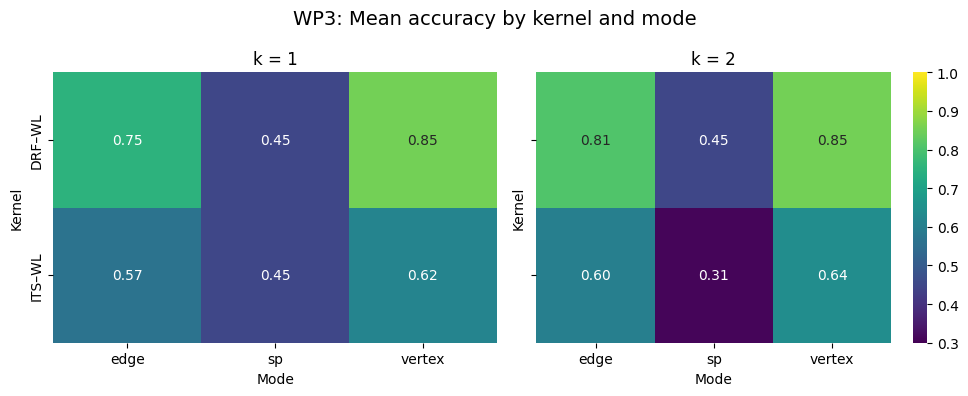

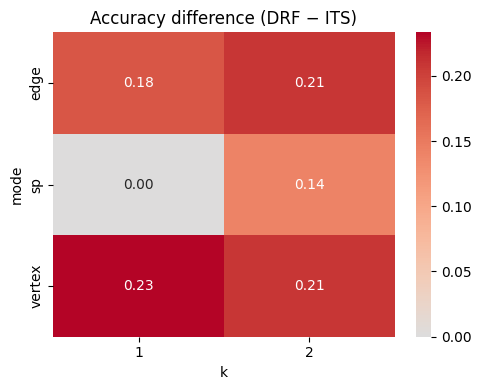

In [28]:
if "k" in df_results.columns and df_results["k"].notna().any():
    plot_heatmaps_by_k(df_results)
    plot_difference_heatmap(df_results)
else:
    print("[WARN] df_results has no k values -> skipping k-based plots.")

# 4. Overview and Suggestions

- the small experiment with k common classes per subset shows that:
    - the accuracy increases if one or two classes are more present in the dataset 
    - -> train the svm with one ore two dominant classes

- -> the DRF performs overall better then ITS
- -> the training on the vertex or edge features is overall better then on the shortest path
    
- **Suggestions**

    - replace the SVM with kernel ridge regression or Gaussian processes using the same precomputed kernels 
        - Kernel Ridge Regression (KRR): closed‑form solver α = (K + λI)⁻¹y — simple to implement and tune, gives continuous scores
        - Gaussian Processes (GP): uses the same Kernel and additionally provides predictive uncertainty (confidence) for each prediction
    - combine DRF and ITS kernels via kernel fusion (e.g. weighted sum):
        - DRF and ITS captures different aspects of a reaction
        - with the weighted sum the overall accuracy could perform better 
        - needs normalization of features in advance
    - use learned embeddings (e.g. GNNs) as input to a kernel method for hybrid approaches:
        - train a GNN (or other learned encoder) to produce compact vector embeddings per reaction
        - use embedding directly with the Kernel method
        - embeddings can learn task‑specific, high‑level patterns that handcrafted kernels miss